In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import pandas as pd
import os
from collections import OrderedDict
import torch


In [3]:
input_data = os.path.join('/home/eilia/calibration_project/fine_tuning/Provo_Corpus.tsv')

In [4]:
predict_norms = pd.read_csv(input_data, sep='\t')
paragraphs = predict_norms.groupby('Text_ID')['Text'].max()

In [5]:
def preprocess_provo_corpus(input_data):
    """Reading the raw Provo Corpus dataset and create a dictionary with all useful 
    information we might need from it"""
    predict_norms = pd.read_csv(input_data, sep='\t')
    paragraphs = predict_norms.groupby('Text_ID')['Text'].max()
    
    paragraphs_provo = {}
    count = 0
    for text_id in range(1,56): #iterate over all provo paragraphs
        for word_num in predict_norms[predict_norms['Text_ID'] == text_id]['Word_Number'].unique(): #iterating over all words in each text
            word_dist = predict_norms[(predict_norms['Text_ID'] == text_id) & (predict_norms['Word_Number'] == word_num)]
            unique_human_words = word_dist['Response'].unique() #all human answered words for each word
            unique_word_dist = []
            for word in unique_human_words:
                unique_word_count = sum(word_dist[word_dist['Response'] == word]['Response_Count']) #getting all counts of the unique word and summing them
                unique_word_dist.append((word, unique_word_count))
            
            remove_noise = [item for item in unique_word_dist]# if item[1] != 1]
            word_dist_dict = dict(remove_noise)
            paragraphs_provo[count] = {}
            paragraphs_provo[count]['human_dist_over_next_word_pred'] = word_dist_dict 
            paragraphs_provo[count]['context_with_cloze_word'] = paragraphs[text_id].split(' ')[:int(word_num)]
            paragraphs_provo[count]['original_positioning'] = {'text_id':text_id, 'word_num':word_num}
            #store the distribution dictionary in a dictionary for each text word (and their position in the text - in case of duplicate words) 

            count = count + 1  

    return paragraphs_provo


In [6]:
paragraphs_provo = preprocess_provo_corpus(input_data)

In [1]:
def model_unbiased(data_per_context):
    #Check for failed to generate full-word samples and remove those
    fail = [d for d in data_per_context['ancestral_samples'] if d['pred'] == 'Failed to generate word']
    if len(fail) > 0:
        data_per_context['ancestral_samples'].remove(fail[0])
        
    #remove duplicates (from lowercasing)
    support_model = [x['pred'].lower() for x in data_per_context['ancestral_samples']]
    counts_model = [x['count'] for x in data_per_context['ancestral_samples']]
    dist = [[support_model[i], counts_model[i]] for i in range(len(counts_model))]
    words = set(map(lambda x:x[0], dist))
    merged_list = [[y[1] for y in dist if y[0]==x] for x in words]
    merged_counts = [sum(x) for x in merged_list]
    probs = [x/sum(merged_counts) for x in merged_counts]

    dist_model = [(list(words)[i], probs[i]) for i in range(len(list(words)))]
    #sort by highest probability
    dist_model.sort(reverse=True, key=lambda a: a[1])
    top_15_model = dist_model[:15]
    support_unbiased_model = [x[0] for x in top_15_model]
    probs_unbiased_model = [x[1] for x in top_15_model]

    return support_unbiased_model, probs_unbiased_model

def model_biased(data_per_context):
    support_model = []
    support_model.append(data_per_context['original'])
    support_model.append(data_per_context['greedy'])
    support_model = support_model + data_per_context['human']
    support_model = support_model + data_per_context['ancestral_samples']
    for p in data_per_context['nucleus_samples']['top-p'].keys():
        support_model = support_model + data_per_context['nucleus_samples']['top-p'][p]
        
    #remove duplicate entries for the same prediction
    list_unique_words = OrderedDict([(d['pred'].lower(), d['cond_log_prob']) for d in support_model]).items()
        
    #All words and scores that belong to the biased estimator distribution
    support_model = [ x[0] for x in list_unique_words ] 
    scores = torch.Tensor([ x[1] for x in list_unique_words ])
    log_probs = scores - torch.logsumexp(scores, -1, keepdims=True)  #stable softmax
    counts_model = torch.exp(log_probs) #log probs to probs
    
    dist_model = [(support_model[i], counts_model[i]) for i in range(len(counts_model))]
    #sort by highest probability
    dist_model.sort(reverse=True, key=lambda a: a[1])
    top_15_model = dist_model[:15]
    support_biased_model = [x[0] for x in top_15_model]
    probs_biased_model = [x[1] for x in top_15_model]

    return support_biased_model, probs_biased_model

In [22]:
def human_and_model_dist(word_num, text, data_improved_model, model):
    context = data_improved_model[text][word_num]['context']['text']
    
    support_human = [x['pred'].lower() for x in data_improved_model[text][word_num]['human']]
    counts_human = [x['count'] for x in data_improved_model[text][word_num]['human']]
    counts_human = [x / sum(counts_human) for x in counts_human]
    dist_human = [(support_human[i], counts_human[i]) for i in range(len(counts_human))]
    #sort by highest probability
    dist_human.sort(reverse=True, key=lambda a: a[1])
    top_15_human = dist_human[:15]
    support_original_human = [x[0] for x in top_15_human]
    probs_original_human = [x[1] for x in top_15_human]
    prob_mass_human = sum(probs_original_human)
    
    if model == 'unbiased':
        support_model, probs_model = model_unbiased(data_improved_model[text][word_num])
        prob_mass_unbiased = sum(probs_model)
    elif model == 'biased':
        support_model, probs_model = model_biased(data_improved_model[text][word_num])
    elif model == 'both':
        support_unbiased_model, probs_unbiased_model = model_unbiased(data_improved_model[text][word_num])
        support_biased_model, probs_biased_model = model_biased(data_improved_model[text][word_num])

    print('Context: ' + context + ' (Length: ' + str(int(word_num) - 1) + ')')
    print('human probability mass shown', prob_mass_human)
    print('model probability mass shown', prob_mass_unbiased)

    
    plt.rc('font', size=40)# controls default text sizes

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.bar(support_original_human, probs_original_human, alpha=0.5, label = 'Human Distribution (Prob. mass shown:' + "{:.2f}".format(prob_mass_human) + ')', color = 'orangered', hatch='//')
    ax.bar(support_model, probs_model, alpha=0.5, label = 'Model Distribution (Prob. mass shown:' + "{:.2f}".format(prob_mass_unbiased) + ')', color = 'dodgerblue', hatch = '.')
    ax.legend(loc=1, prop={'size': 35})

    ax.set_xlabel('Word', fontsize=40)
    ax.set_ylabel('Probability', fontsize=40)
    ax.set_title('Context: ' + context[:38] + '\n' + context[38:87] + '\n' +  context[87:137] , size = 40,fontweight="bold")
    #ax.set_title('Context: ' + context[:41] + '\n' + context[41:89] + '\n' +  context[89:137] + '\n' + context[137:187] + '\n' + context[187:238] + '\n' + context[238:280] + '\n' + context[280:330] + '\n' + context[330:], size = 40,fontweight="bold")
    # + '\n' + context[41:89] +  '\n' +  context[89:136] + '\n' + context[137:]
    ax.tick_params(axis = 'x',labelrotation=90)    

    plt.savefig('dists_' + str(word_num) + 'specific.pdf', format="pdf",bbox_inches='tight') #dpi=300, 
    plt.show()


In [4]:
f = open('/home/eilia/calibration_project/output/data_preprocessing_words/Paragraphs-4-4.json')

data_improved_model = json.load(f)

f.close()

Context: Liza was in a bad temper, for she was mixing the Christmas puddings in the kitchen, and had been drawn (Length: 20)
human probability mass shown 1.0
model probability mass shown 0.8700000000000002


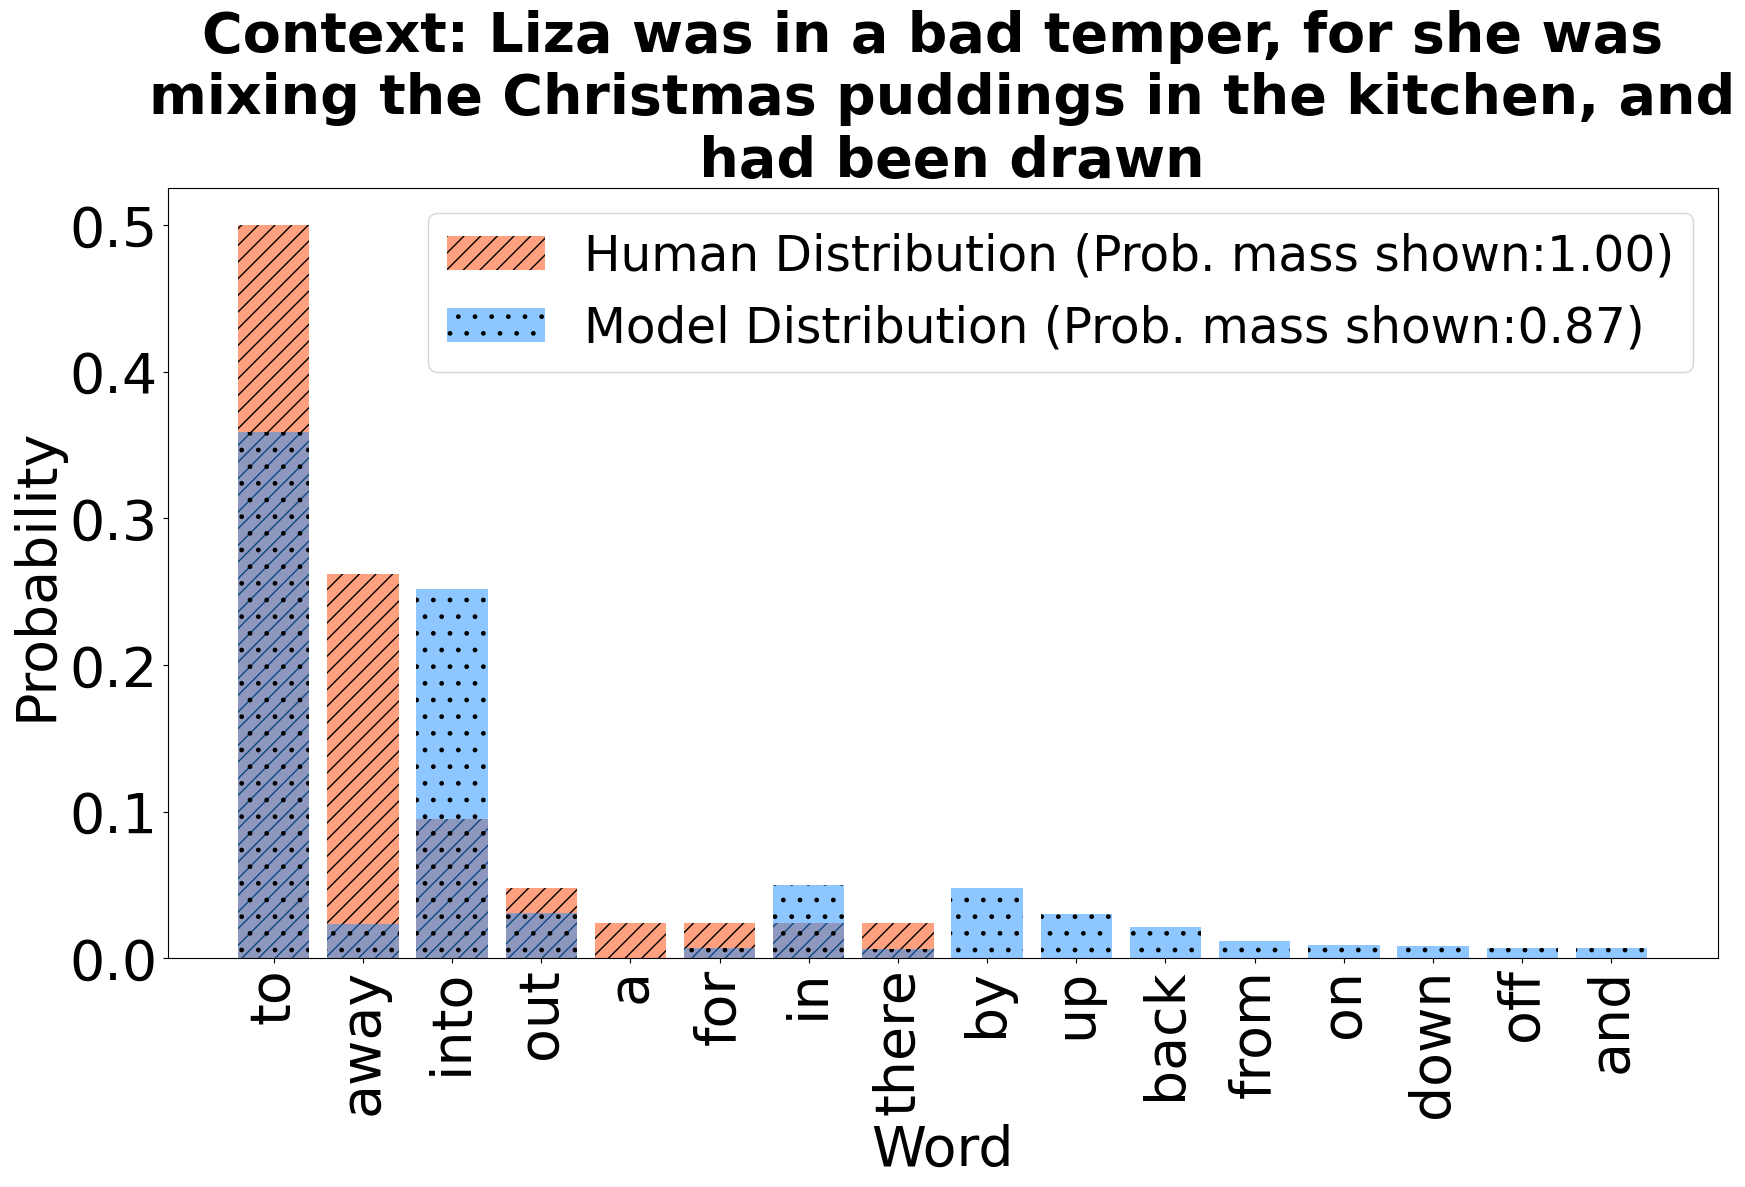

In [23]:
text = '4'
word_num = '21'
human_and_model_dist(word_num, text, data_improved_model, 'unbiased')

Context: The human body can tolerate only a small range of temperature, especially when the person is engaged in vigorous activity. Heat reactions usually occur when large amounts of water and/or salt are lost through excessive sweating following strenuous exercise. When the body becomes overheated and cannot eliminate this excess heat, heat (Length: 51)
human probability mass shown 0.8837209302325583
model probability mass shown 0.35400000000000004


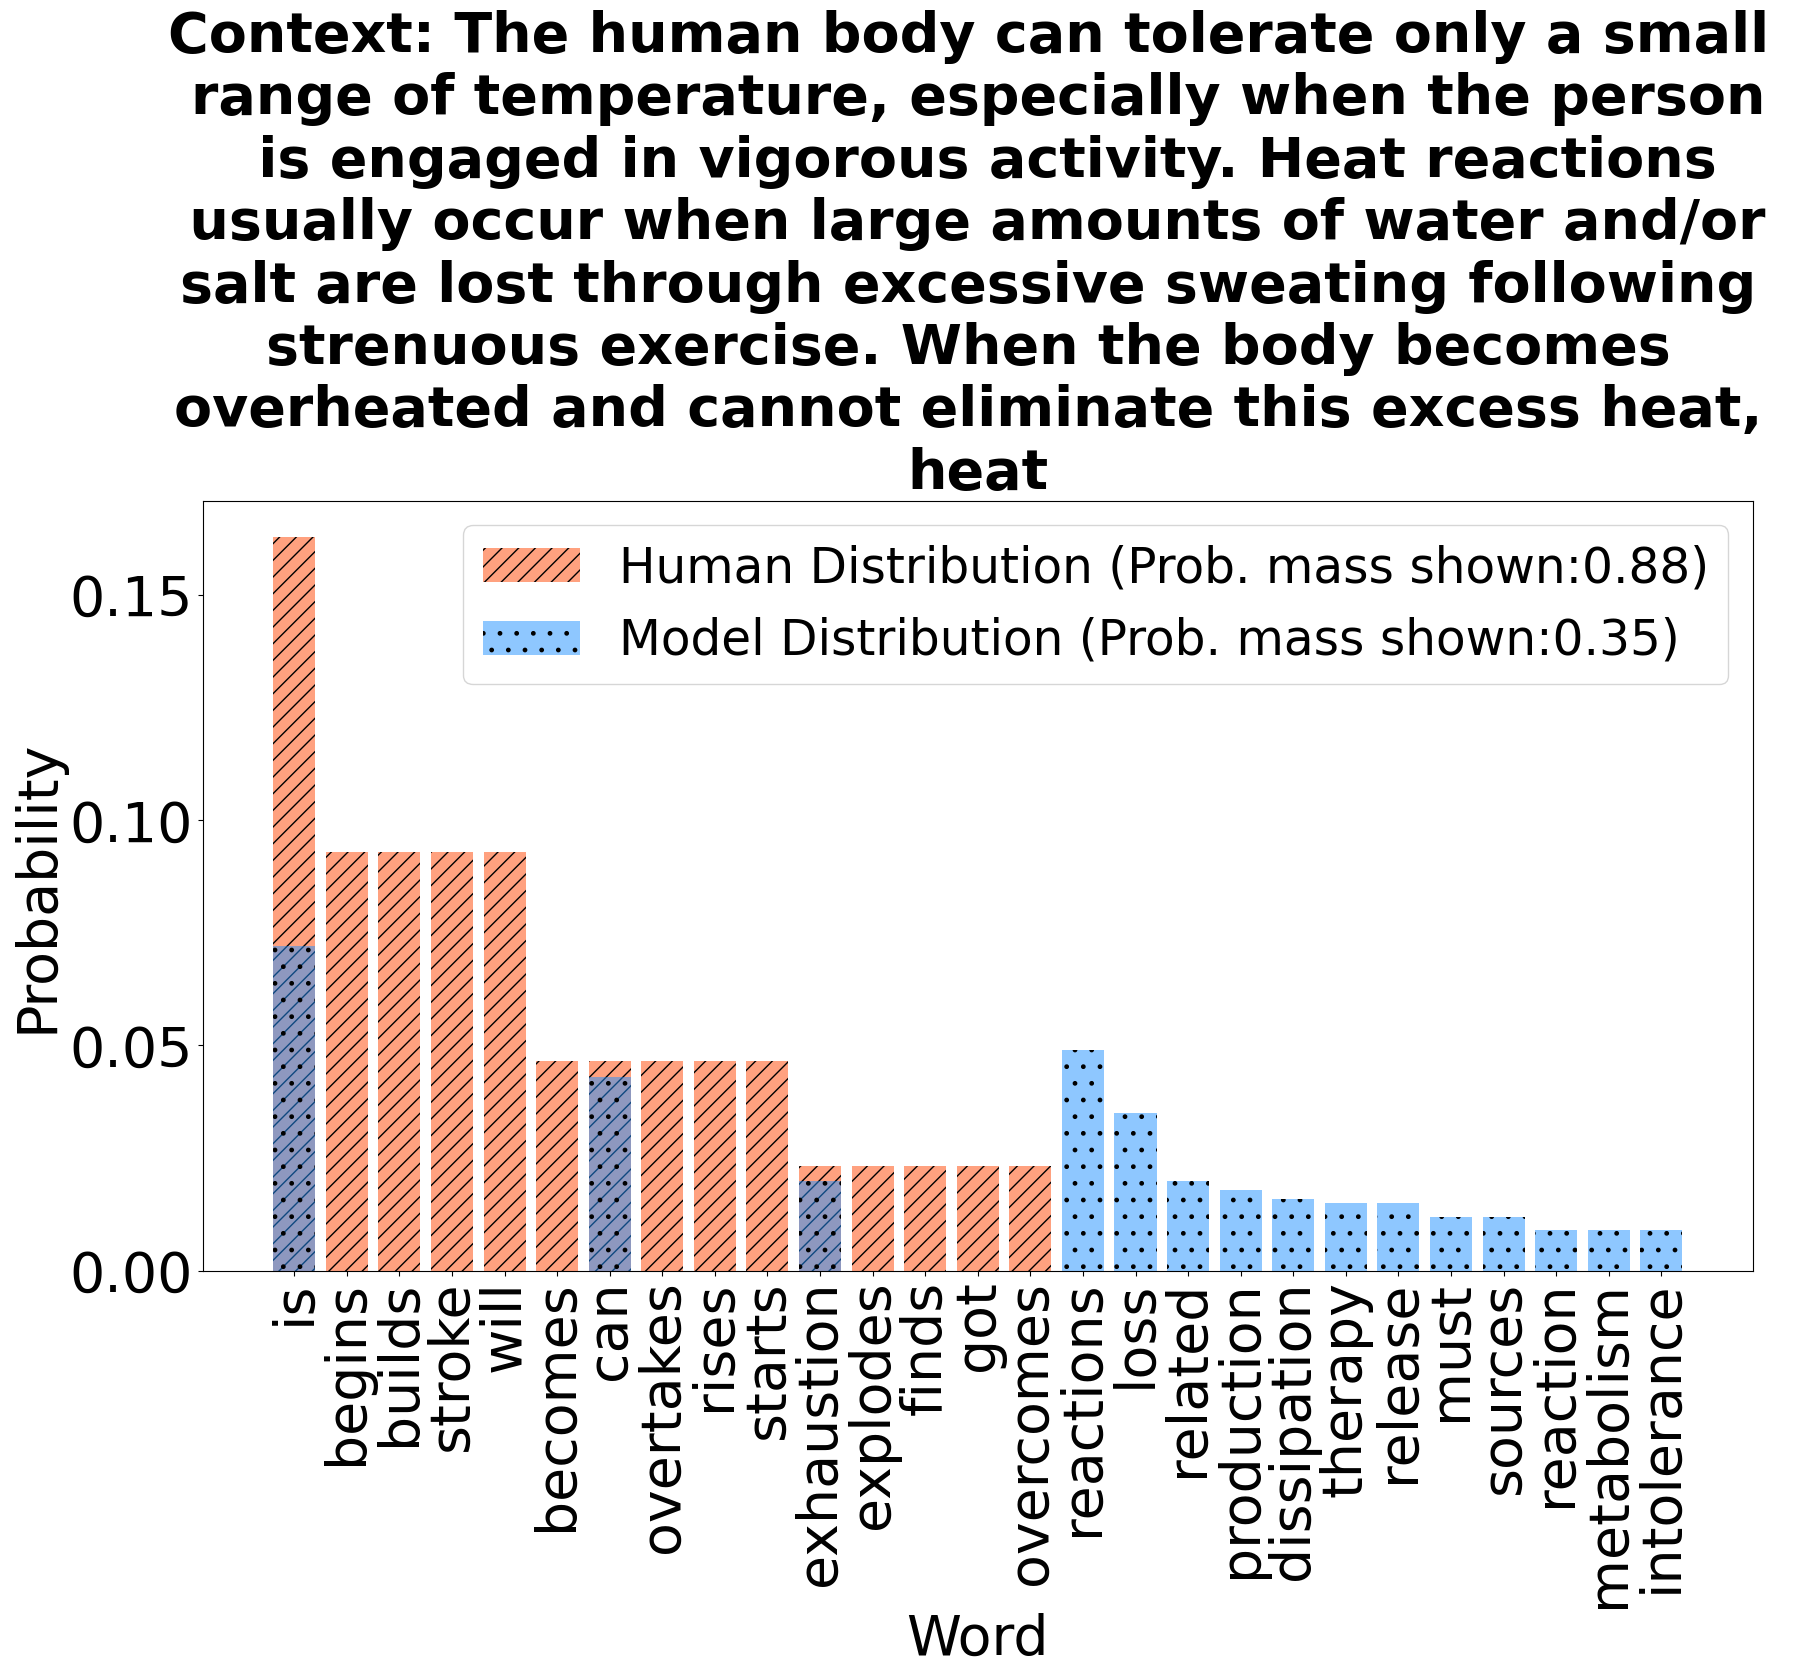

Context: The human body can tolerate only a small range of temperature, especially when the person is engaged in vigorous activity. Heat reactions usually occur when large amounts of water and/or salt are lost through excessive sweating following strenuous exercise. When the body becomes overheated and cannot eliminate this excess heat, heat exhaustion (Length: 52)
human probability mass shown 0.9767441860465117
model probability mass shown 0.7680000000000001


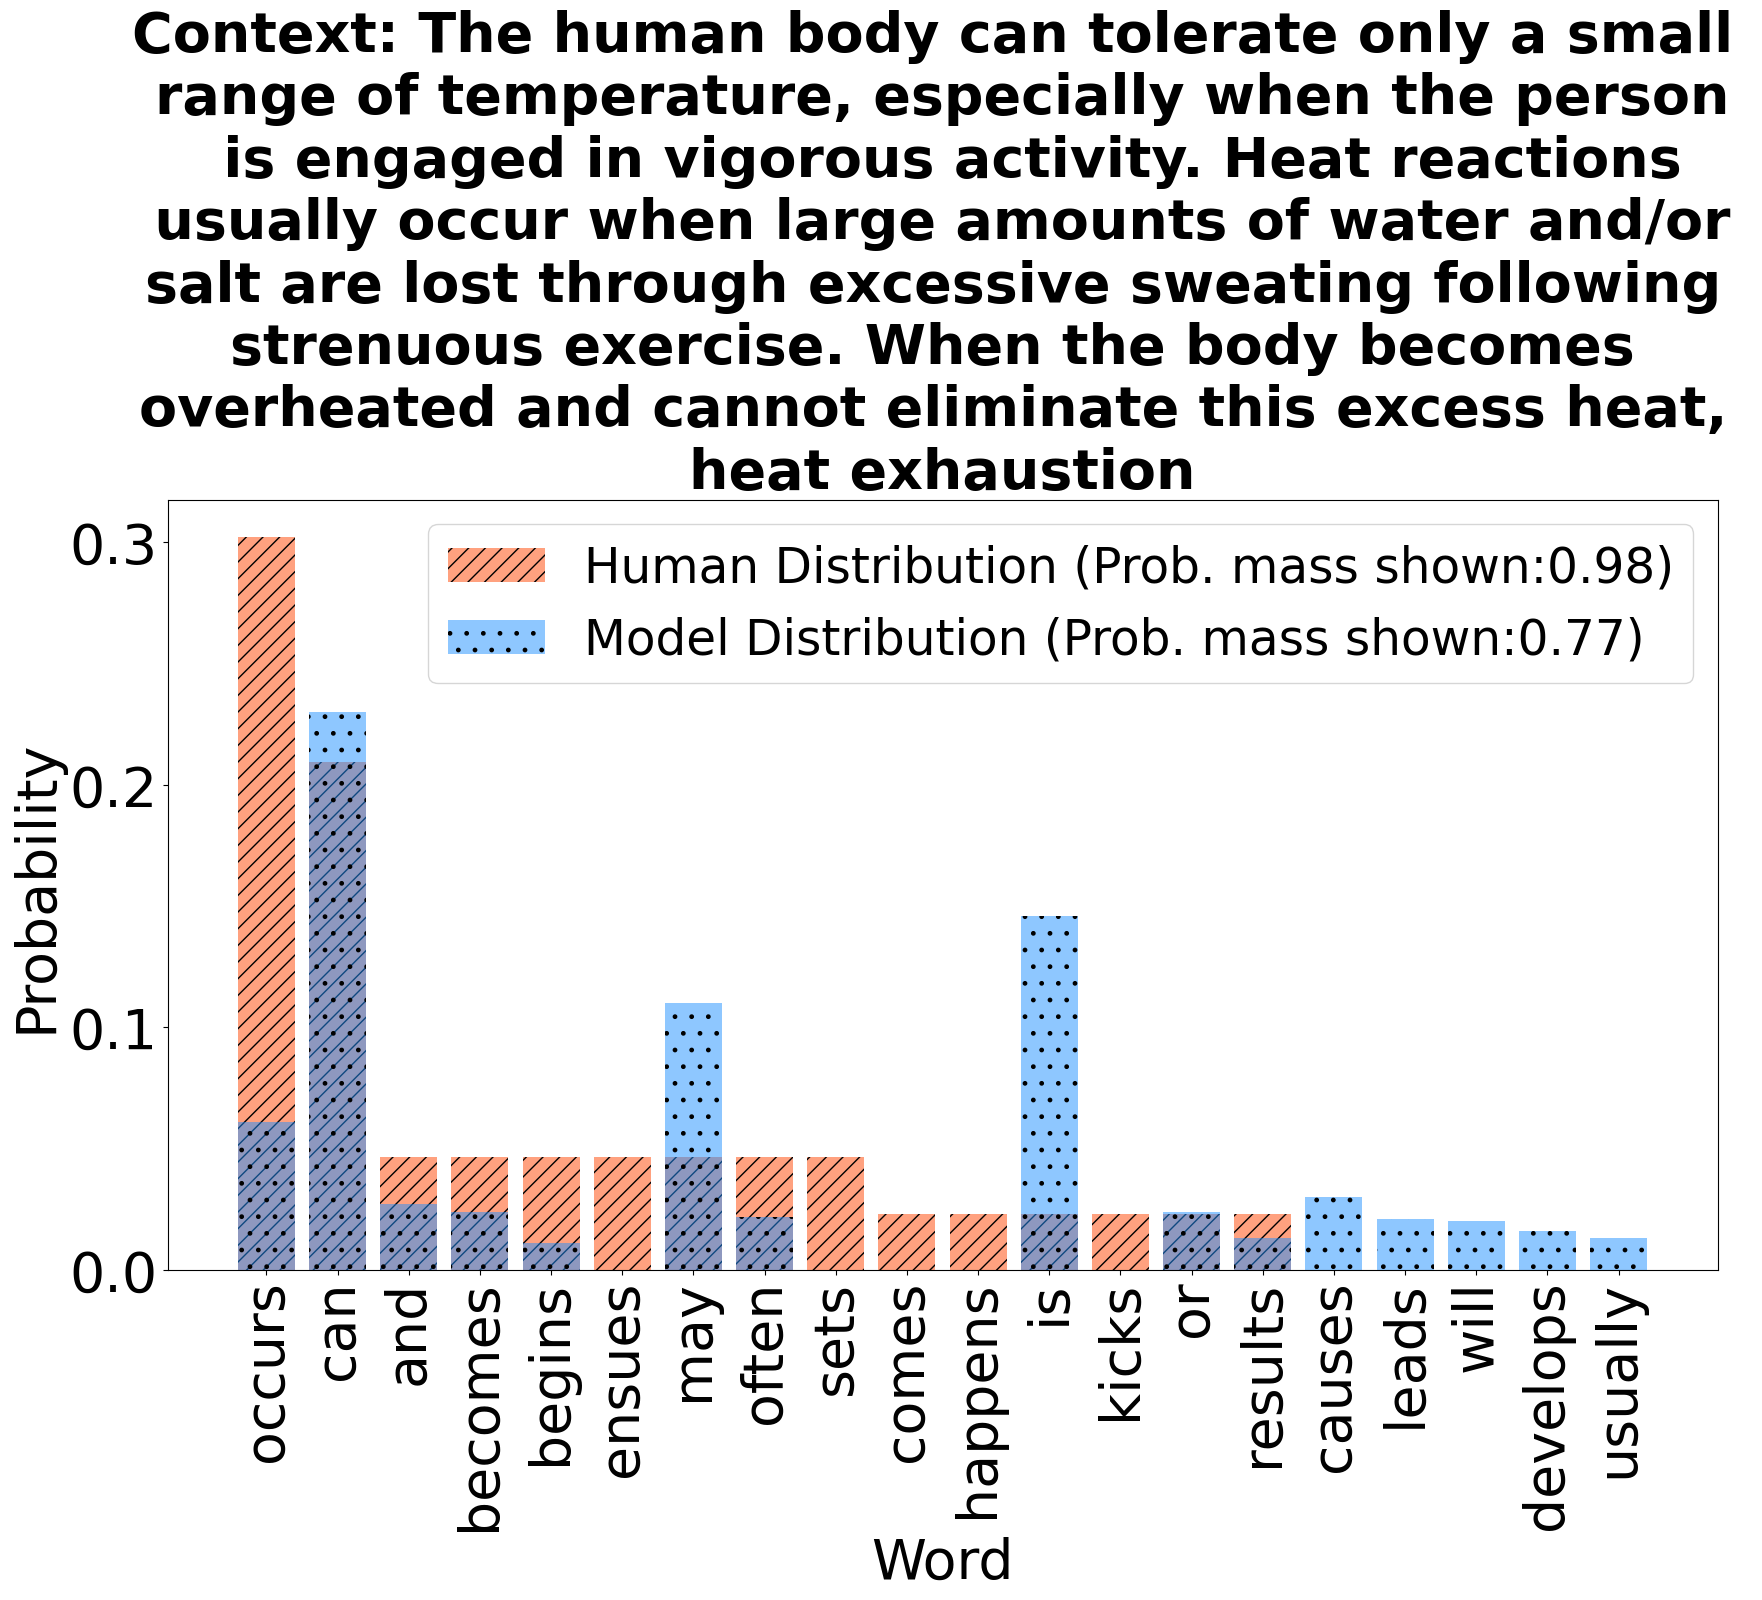

Context: The human body can tolerate only a small range of temperature, especially when the person is engaged in vigorous activity. Heat reactions usually occur when large amounts of water and/or salt are lost through excessive sweating following strenuous exercise. When the body becomes overheated and cannot eliminate this excess heat, heat exhaustion and (Length: 53)
human probability mass shown 0.9767441860465119
model probability mass shown 0.5080000000000001


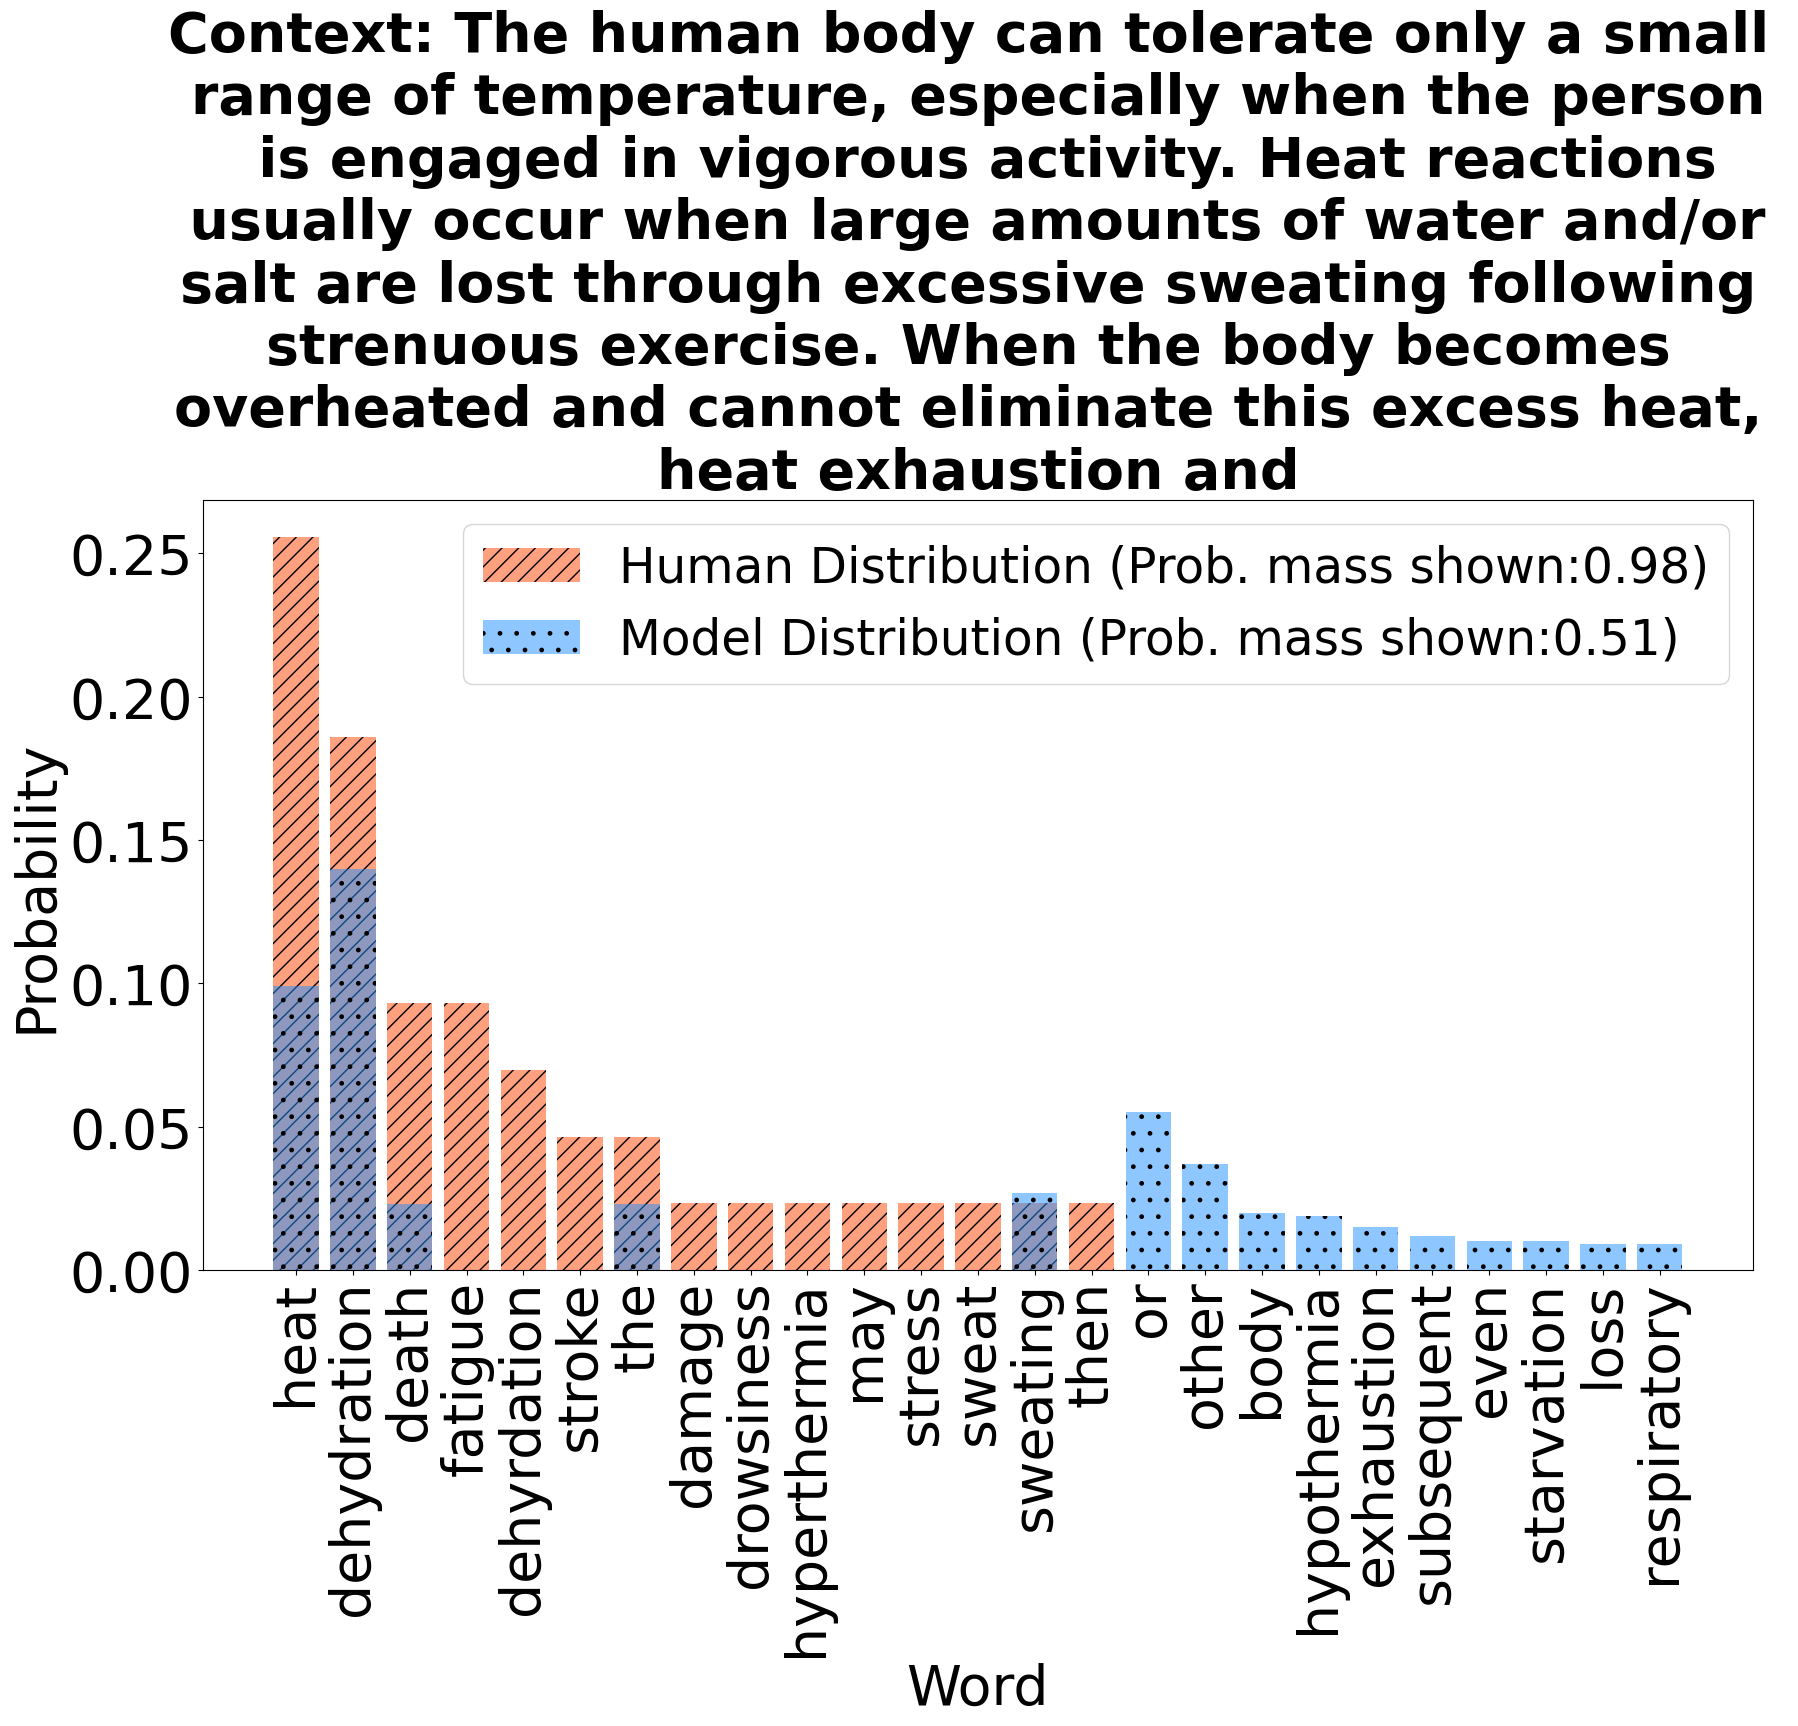

Context: The human body can tolerate only a small range of temperature, especially when the person is engaged in vigorous activity. Heat reactions usually occur when large amounts of water and/or salt are lost through excessive sweating following strenuous exercise. When the body becomes overheated and cannot eliminate this excess heat, heat exhaustion and heat (Length: 54)
human probability mass shown 0.9534883720930237
model probability mass shown 0.6210000000000001


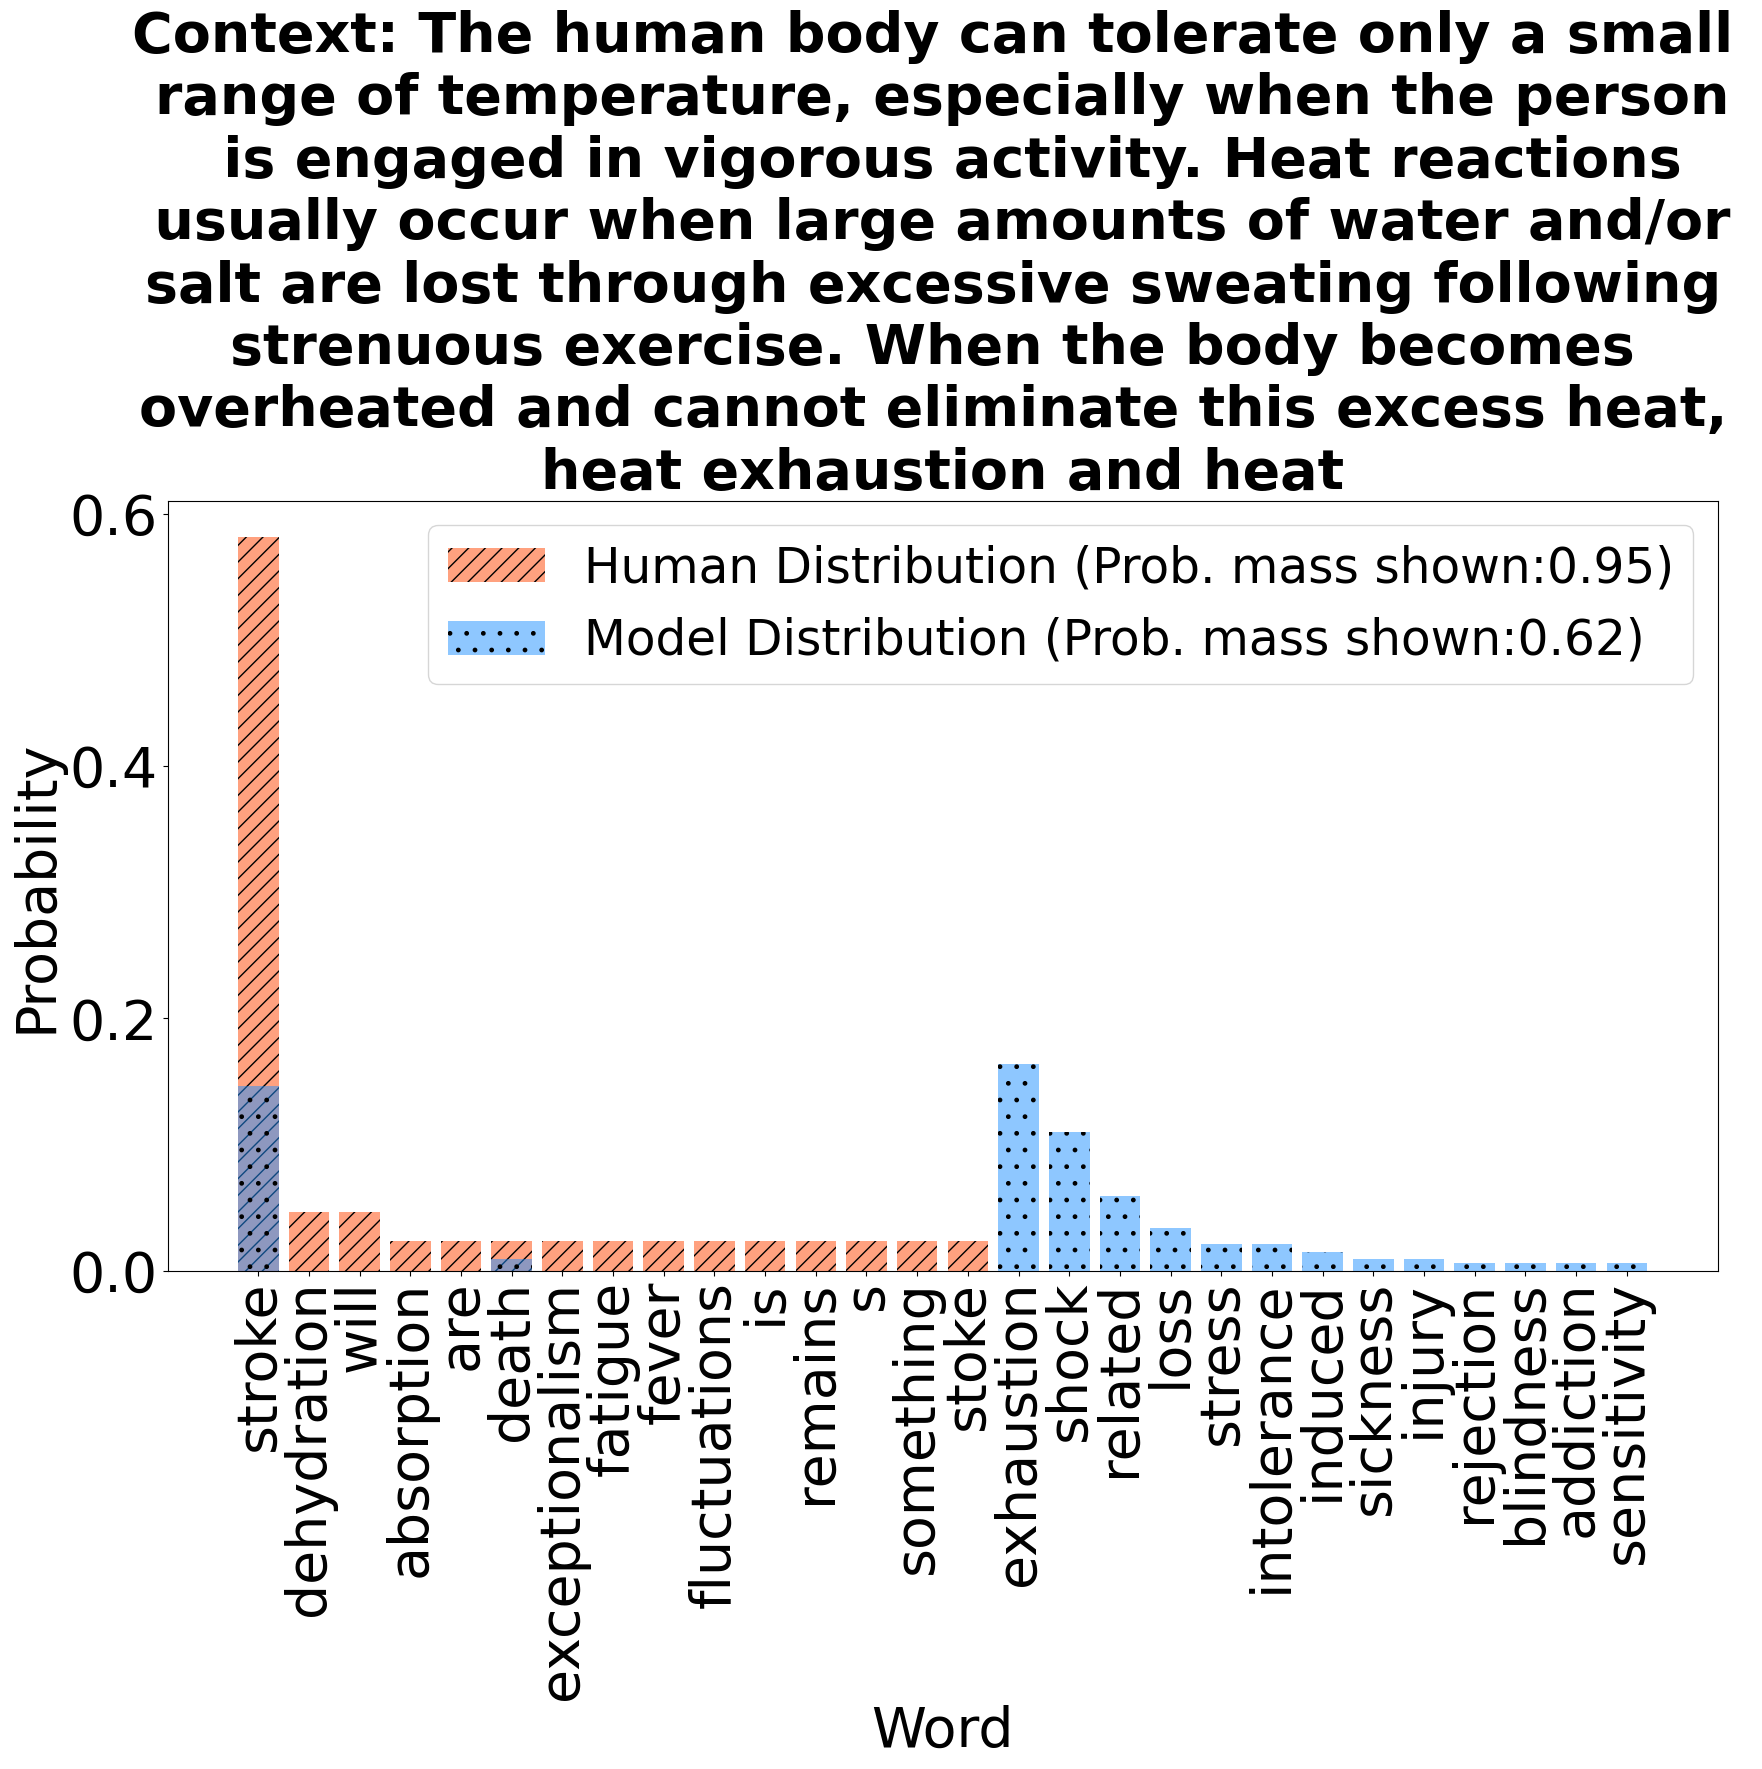

Context: The human body can tolerate only a small range of temperature, especially when the person is engaged in vigorous activity. Heat reactions usually occur when large amounts of water and/or salt are lost through excessive sweating following strenuous exercise. When the body becomes overheated and cannot eliminate this excess heat, heat exhaustion and heat stroke (Length: 55)
human probability mass shown 1.0000000000000002
model probability mass shown 0.804


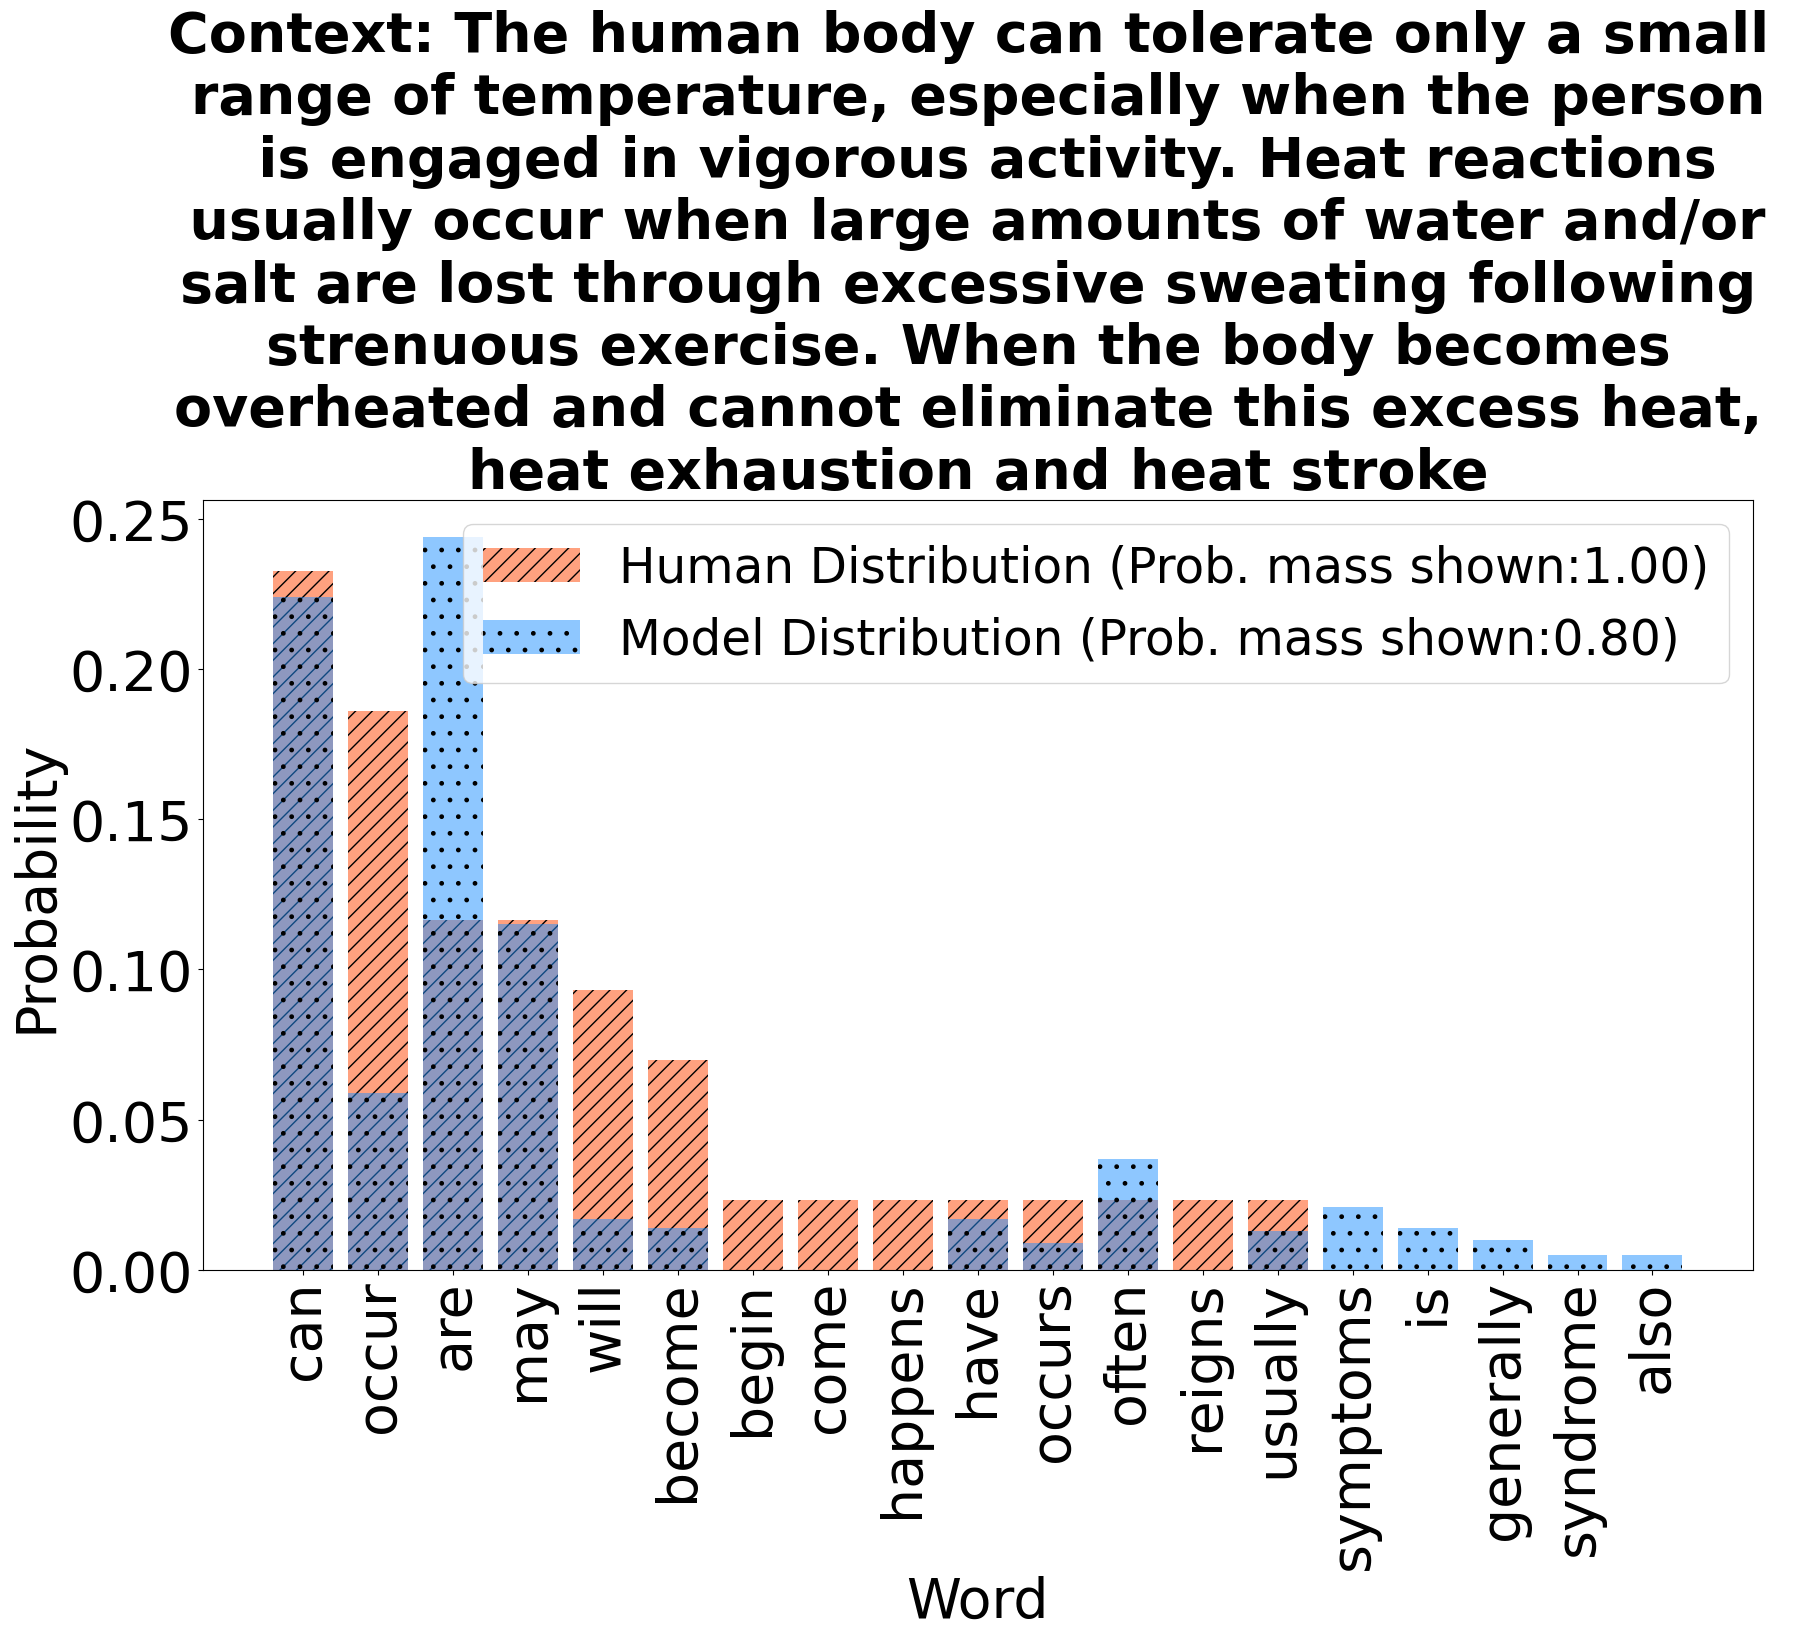

Context: The human body can tolerate only a small range of temperature, especially when the person is engaged in vigorous activity. Heat reactions usually occur when large amounts of water and/or salt are lost through excessive sweating following strenuous exercise. When the body becomes overheated and cannot eliminate this excess heat, heat exhaustion and heat stroke are (Length: 56)
human probability mass shown 0.7906976744186051
model probability mass shown 0.5750000000000002


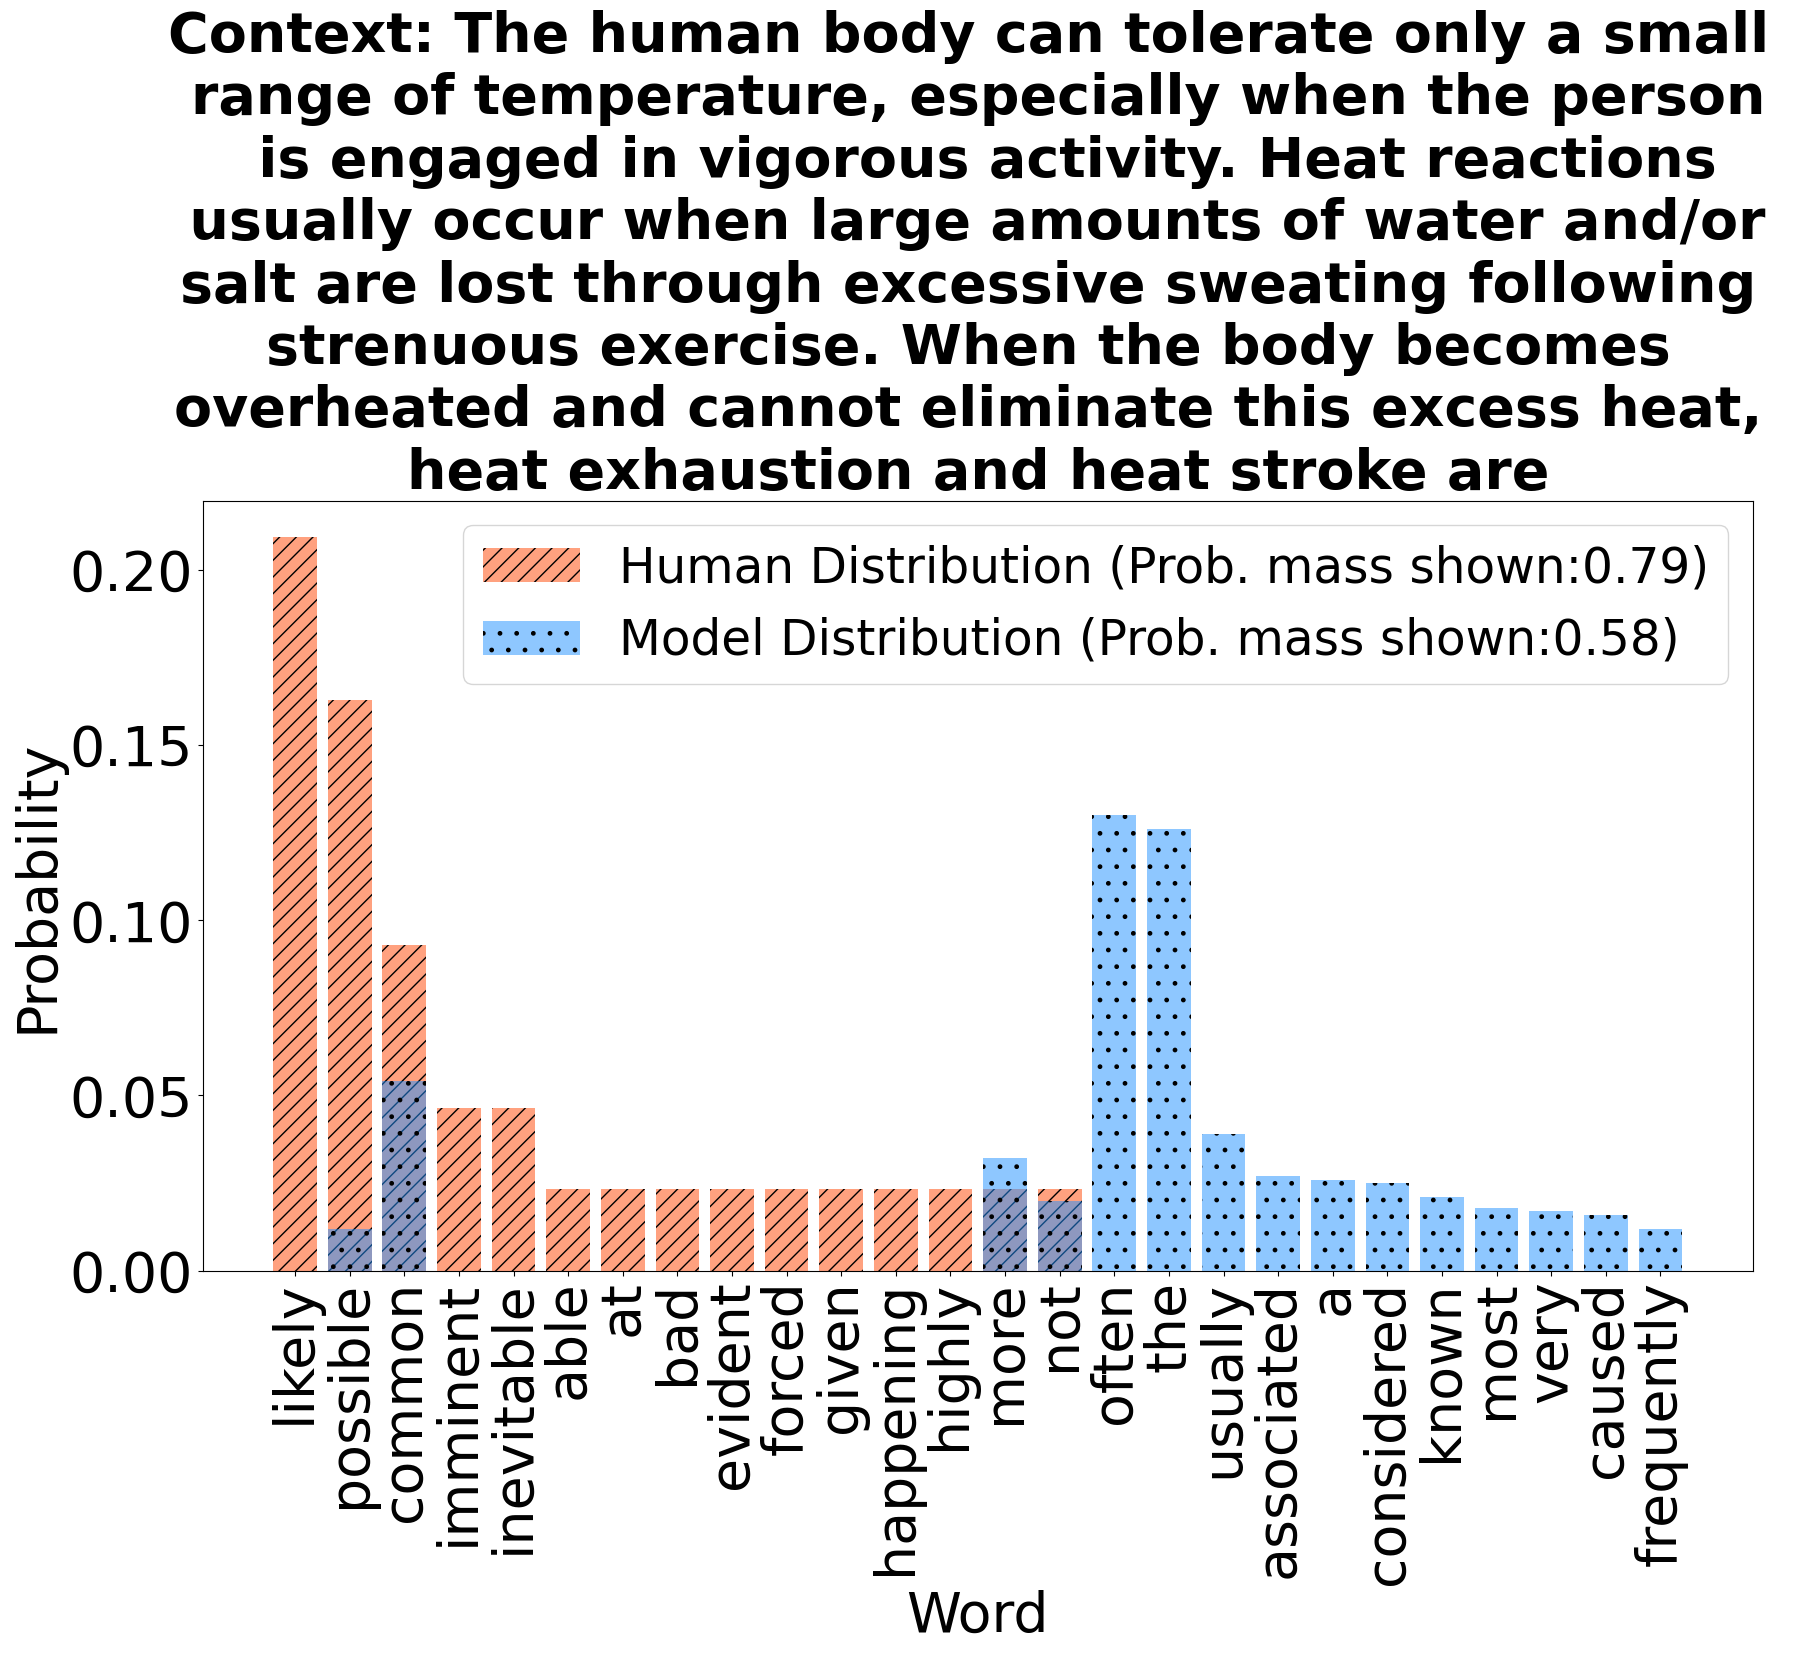

In [88]:
os.path.join(os.getcwd(), 'dists')
text = '4'
for i in range(52, 58): #(2,58)
    word_num = str(i)
    human_and_model_dist(word_num, text, data_improved_model, 'unbiased')